In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

total samples:  5573
ham:  4825
spam:  748


<BarContainer object of 2 artists>

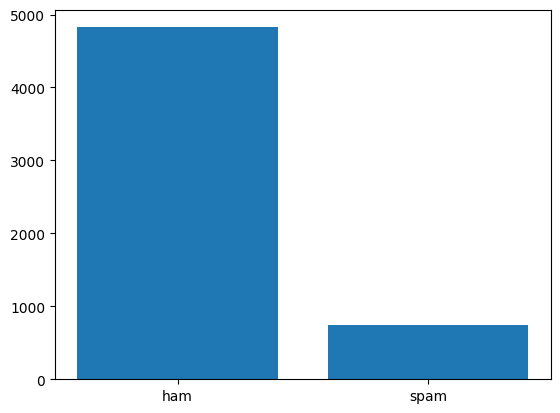

In [3]:
data = pd.read_csv('./spam_detection.csv', header=None)
print("total samples: ", data[0].count())
data = (data[0] == "ham").to_numpy()

ham = data.sum()
spam = data.size - ham

print("ham: ", ham)
print("spam: ", spam)

plt.bar(["ham", "spam"], [ham, spam])

In [10]:
words_map = {'\0':0}
sentence_len = 64
data_dir = './spam_detection.csv'
train_test_pro = 0.7
stop_words = set(stopwords.words('english'))

def initData(data_directory = './spam_detection.csv'):
    k = 0
    data_ = {0 : [], 1 : []}
    data = pd.read_csv(data_directory, header=None)

    for i in range(len(data[0])):
        data[1][i] = [word for word in word_tokenize(data[1][i]) if word not in stop_words]
        for word in data[1][i]:
            if word not in words_map:
                words_map[word] = k
                k += 1
        data[1][i] = [words_map[word] for word in data[1][i]]
        data[1][i] = [0] * (sentence_len - len(data[1][i])) + data[1][i]
        data[1][i] = torch.tensor(data[1][i])
        if data[0][i] == 'ham':
            data_[0].append(data[1][i])
        else:
            data_[1].append(data[1][i])

    len_ = min(len(data_[1]), len(data_[0]))

    data_[0] = data_[0][1:len_]
    data_[1] = data_[1][1:len_]
    return data_, len_ - 1


class SpamData(Dataset):
    def __init__(self, data_directory, train=True, rt=0.7):
        self.data_, self.len_ = initData(data_directory)
        mid = (int) (self.len_*rt)
        if train:
            self.data_[0] = self.data_[0][0:mid]
            self.data_[1] = self.data_[1][0:mid]
            self.len_ = mid
        else:
            self.data_[0] = self.data_[0][mid:]
            self.data_[1] = self.data_[1][mid:]
            self.len_ = self.len_ - mid

    def __len__(self):
        return self.len_ * 2

    def __getitem__(self, index):
        if (index % 2 == 1):
            return 1, self.data_[1][index % self.len_]
        return 0, self.data_[0][index % self.len_]

In [17]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Transmodel(nn.Module):
    def __init__(self):
        super(Transmodel, self).__init__()
        embed_dim = 48
        self.embed = nn.Embedding(len(words_map), embed_dim)
        layer = nn.TransformerEncoderLayer(embed_dim, 4)
        self.transen = nn.TransformerEncoder(layer, 4)
        self.ln = nn.Linear(embed_dim * sentence_len, sentence_len)
        self.lno = nn.Linear(sentence_len, 1)
        self.pose = PositionalEncoding(embed_dim)

    def forward(self, input):
        r = self.embed(input)
        r = self.pose(r)
        r = torch.reshape(r, (input.size()[0],-1))
        r = self.ln(r)
        r = self.lno(r)
        return torch.sigmoid(r)

class LSTMmodel(nn.Module):
    def __init__(self):
        super(LSTMmodel, self).__init__()
        self.embed = nn.Embedding(len(words_map), 32)
        self.lstm = nn.LSTM(32, 64, 4, batch_first=True)
        self.ln = nn.Linear(64, 1)
        self.lno = nn.Linear(sentence_len, 1)

    def forward(self, input):
        r = self.embed(input)
        r = self.lstm(r)[0]
        r = self.ln(r)
        r = torch.reshape(r, (input.size()[0],-1))
        r = self.lno(r)
        return torch.sigmoid(r)
    
def train(yrmodel='lstm', epochs=2, lr=0.0005, batch_size=16):
    data = SpamData(data_dir, True, 1)
    data_test = SpamData(data_dir, True, 1)

    model = None

    if yrmodel == "lstm":
        model = LSTMmodel()
    else:
        model = Transmodel()
    data_test_size = len(data_test)

    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criteria = torch.nn.BCELoss()

    for i in range(epochs):
        for out, inp in dataloader:
            out = torch.reshape(out, (-1,1)).float()
            pred = model(inp)
            loss = criteria(pred, out)
            loss.backward()
            optimizer.step()
        
        if i % 1 == 0:
            prob = 0
            for j in range(len(data_test)):
                out, inp = data_test[j]
                with torch.no_grad():
                    inp = torch.reshape(inp, (1, -1))
                    pred = model(inp)
                    a = (model(inp)-0.5)*(out-0.5)
                    if a >= 0:
                        prob += 1
            
            print(f"epoch {i}  acc: {prob * 1.0 / data_test_size}")
    return model


In [13]:
modellstm = train(epochs=10, lr=0.0002)

epoch 0  acc: 0.6157965194109772
epoch 1  acc: 0.6144578313253012
epoch 2  acc: 0.5281124497991968
epoch 3  acc: 0.8145917001338688
epoch 4  acc: 0.9263721552878179
epoch 5  acc: 0.9578313253012049
epoch 6  acc: 0.9390896921017403
epoch 7  acc: 0.9551539491298527
epoch 8  acc: 0.9765729585006694
epoch 9  acc: 0.9819277108433735


In [25]:
modeltrans = train(yrmodel="trans", lr=0.00015,epochs=60)

epoch 0  acc: 0.5
epoch 1  acc: 0.5
epoch 2  acc: 0.5
epoch 3  acc: 0.5
epoch 4  acc: 0.6164658634538153
epoch 5  acc: 0.8199464524765729
epoch 6  acc: 0.7938420348058902
epoch 7  acc: 0.7904953145917001
epoch 8  acc: 0.8346720214190094
epoch 9  acc: 0.8360107095046854
epoch 10  acc: 0.8279785809906292
epoch 11  acc: 0.8179384203480589
epoch 12  acc: 0.8085676037483266
epoch 13  acc: 0.8145917001338688
epoch 14  acc: 0.8299866131191432
epoch 15  acc: 0.8467202141900937
epoch 16  acc: 0.8554216867469879
epoch 17  acc: 0.8668005354752343
epoch 18  acc: 0.8862115127175368
epoch 19  acc: 0.9069611780455153
epoch 20  acc: 0.9156626506024096
epoch 21  acc: 0.9163319946452476
epoch 22  acc: 0.9196787148594378
epoch 23  acc: 0.9250334672021419
epoch 24  acc: 0.9250334672021419
epoch 25  acc: 0.9230254350736279
epoch 26  acc: 0.9250334672021419
epoch 27  acc: 0.9270414993306559
epoch 28  acc: 0.9263721552878179
epoch 29  acc: 0.928380187416332
epoch 30  acc: 0.9323962516733602
epoch 31  acc: 0.

In [27]:
sen = '''FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, to rcv'''

data = [words_map[word] for word in word_tokenize(sen) if word not in stop_words]
data = [0] * (sentence_len - len(data)) + data
data = torch.tensor(data)
data = torch.reshape(data,(1,-1))

print("1 means spam, 0 means ham")
print("lstm model: ", modellstm(data).item())
print("transformer model: ", modeltrans(data).item())

1 means spam, 0 means ham
lstm model:  0.5147634744644165
transformer model:  1.0
